# Propensity to fund mortgages: ensemble models

Author: Yoann Pradat

Competition hosted on crowdanalytix.com. It aims at predicting whether a mortgage will be funded or not based on applicant's data. It is therefore a binary classification problem.

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import pandas as pd

import os
import sys

import itertools
import time
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from imblearn.over_sampling import SMOTENC

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Utils data

In [2]:
# -*- coding: utf-8 -*-
"""
Usefuls functions for processing data
Python 3 virtual environment 3.7_pytorch_sk or base conda

@date: 5th May 2019
@author: Yoann Pradat
"""

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import clone

class Ignore(BaseEstimator, TransformerMixin):
    def __init__(self, cols_ignore):
        self.cols_ignore=cols_ignore
    def fit(self, X, y):
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_ignore:
            del Xc[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, cols_num, eps=1e-1):
        self.cols_num=cols_num
        self.esp = eps
    def fit(self, X, y):
        self.tds_upper = X.tds.quantile(0.99)
        self.gds_upper = X.gds.quantile(0.99)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        # Indicator of extreme values
        Xc.loc[:, 'tds_le_0'] = np.where(Xc.tds <= 0, 1, 0)
        Xc.loc[:, 'ltv_gt_80'] = np.where(Xc.ltv > 80, 1, 0)
        # Clip too extreme values of tds and tmgds
        Xc.loc[:, 'tds'] = Xc.tds.clip(lower=0, upper=self.tds_upper)
        Xc.loc[:, 'gds'] = Xc.gds.clip(lower=0, upper=self.gds_upper)
        # Log transform
        eps = 1e-1
        for x in self.cols_num:
            Xc.loc[:, x] = np.log10(Xc[x] + eps)
        # As gds and tds are very correlated (0.99) we will only keep tds and add feature tds - gds
        Xc.loc[:, 'tmgds'] = Xc.loc[:, 'tds'] - Xc.loc[:, 'gds']
        del Xc['gds']
        return Xc  

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, center=True, norm_ord=2):
        self.center=center
        self.norm_ord=norm_ord
    def fit(self, X, y):
        n, _ = X.shape
        self.centers = {}
        self.norms = {}
        for x in X:
            if X[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                center = np.mean(X[x])
                norm = np.linalg.norm(X[x]-center)
                self.centers[x] = center
                self.norms[x] = norm/np.sqrt(n)
            else:
                norm = np.linalg.norm(X[x]-center, ord=norm_ord)
                self.norms[x] = norm/np.sqrt(n)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in Xc:
            if Xc[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                Xc.loc[:, x] = (Xc[x]-self.centers[x])/self.norms[x]
            else:
                Xc.loc[:, x] = Xc[x]/self.norms[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

class HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_lim=0.005):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.category_other = {}
        for x, category in zip(self.cols_onehot, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
        Xc = pd.DataFrame.copy(X)
        for i, x in enumerate(self.cols_onehot):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        self.categories = [Xc[x].unique() for x in self.cols_onehot]
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(Xc[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        Xdummy = self.onehotenc.transform(Xc[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            if 'other' in category:
                del Xdummy['%s_%s' % (x, 'other')]
            else:
                del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class LabEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, categories, other_lim=0.005):
        self.cols_cat = cols_cat
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.encoders = {}
        self.category_other = {}
        for x, category in zip(self.cols_cat, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
            
        Xc = pd.DataFrame.copy(X)
        self.categories = []
        for i, x in enumerate(self.cols_cat):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            self.categories.append(Xc[x].unique())
            encoder = LabelEncoder()
            encoder.fit(Xc[x])
            self.encoders[x] = encoder
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_cat:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            Xc.loc[:, x] = self.encoders[x].transform(Xc[x])
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)


## Utils plot

In [3]:
# Plot learning curve of each param holding all other parameters
# at their optimal value. To be used on the output of a gridserach

def plot_learning_curve(param_grid, best_params, cv_results, params_logscale=[]):
    best_params_plot = {}
    for param_n, param_v in param_grid.items():
        if len(param_v) > 1:
            best_params_plot[param_n] = best_params[param_n]           
    ncols = 2
    nrows = np.int(np.ceil(len(best_params_plot)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ax = ax.flatten()
    
    for i, (param_n, param_v) in enumerate(best_params_plot.items()):
        best_idx = []
        for idx, params  in enumerate(cv_results['params']):
            if all([params[x] == best_params[x] for x in best_params.keys() if x!=param_n]):
                best_idx.append(idx)
                
        param_values = np.array([cv_results['params'][idx][param_n] for idx in best_idx])
        train_scores_mean = np.array([cv_results['mean_train_score'][idx] for idx in best_idx])
        train_scores_std = np.array([cv_results['std_train_score'][idx] for idx in best_idx])
        test_scores_mean = np.array([cv_results['mean_test_score'][idx] for idx in best_idx])
        test_scores_std = np.array([cv_results['std_test_score'][idx] for idx in best_idx])
        
        ax[i].grid()
        ax[i].fill_between(param_values, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax[i].fill_between(param_values, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax[i].plot(param_values, train_scores_mean, 'o-', color="r", label="Training score")
        ax[i].plot(param_values, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[i].set_title('Learning curve for %s' % param_n, fontsize=18, fontweight='bold')
        if param_n in params_logscale:
            ax[i].set_xscale('log')
        ax[i].legend(loc="best")
    if i < 2*nrows-1:
        ax[-1].axis('off')
    plt.show(fig)

# Function useful to plot coefficients from regression or feature importance
# Default parameters are for comparison across 5 splits

def plot_compare_coeffs(list_coeffs, title, list_positions = [-3.5, -1.5, 0, 1.5, 3.5], 
                        list_colors = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_ecolors = ['lightsalmon', 'palegreen', 'lightgray', 'lightskyblue', 'palegoldenrod'], 
                        list_els=['-', '-', '-', '-', '-'], 
                        list_colors_labels = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_labels = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5'], 
                        list_lgd_ls=None, 
                        list_lgd_ls_labels=None, 
                        list_format=['o', 'o', 'o', 'o', 'o']): 
    
    n_coeffs = list_coeffs[0].shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))

    for i, col, ecol, coeffs, els, fmt in zip(list_positions, list_colors, list_ecolors, list_coeffs, list_els, list_format):
        eb = ax.errorbar(x=np.arange(n_coeffs) + i / 10, 
                         y=coeffs.values, 
                         yerr=[coeffs.values, np.zeros(n_coeffs)],
                        fmt=fmt, color=col, ecolor=ecol, elinewidth=3, capsize=0)
        eb[-1][0].set_linestyle(els)

    ax.set_xticks(np.arange(-1, n_coeffs + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = coeffs.index[i - 1][0:20]
    ax.set_xticklabels(labels)

    if n_coeffs >= 15:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('coef', fontweight='bold', fontsize=20)
    ax.set_title("Coeffs of %s" % title, fontweight='bold', size=25)

    ax.xaxis.grid(which='major', linewidth=0.2)
    ax.yaxis.grid(which='major', linewidth=0.35, linestyle="--")
    ax.axhline(0, color='gray', linewidth=0.5)

    custom_lines = []
    for c in list_colors_labels:
        custom_lines.append(Line2D([0], [0], color=c, ls="-", lw=4))

    if list_lgd_ls_labels is None:
        ax.legend(custom_lines, list_labels)
    else:
        custom_lines.append(Line2D([0], [0], color='gray', ls='-', lw=0))
        for ls in list_lgd_ls:
            custom_lines.append(Line2D([0], [0], color='gray', ls=ls, lw=2))
        ax.legend(custom_lines, list_labels+['']+list_lgd_ls_labels)

    if n_coeffs >= 15:
        fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.90, wspace=0.4)
    else:
        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90)

    plt.show(fig)

## Utils model

In [4]:
def f1_macro(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    precisions = {}
    recalls = {}
    f1s = {}
    for cl in np.unique(y_true):
        if sum(y_pred==cl)==0:
            precision = 0
        else:
            precision = sum((y_pred==cl) & (y_true==cl))/sum(y_pred==cl)
        if sum(y_true==cl)==0:
            print("Warning! Ill-defined f1-score as no label of the class is in y_true")
            recall = 0
        else:
            recall = sum((y_pred==cl) & (y_true==cl))/sum(y_true==cl)
        
        if recall+precision == 0:
            f1 = 0
        else:
            f1 = 2*recall*precision/(recall + precision)
        precisions[cl] = precision
        recalls[cl] = recall
        f1s[cl] = f1
    return precisions, recalls, f1s


def softmax(X):
    return np.exp(X)/np.sum(np.exp(X), axis=1).reshape(-1, 1)

## Dataset

In [5]:
class MortgageData(object):
    def __init__(self, train_file="../data/CAX_MortgageModeling_Train.csv", test_file="../data/CAX_MortgageModeling_Test.csv", 
                 encoder="Hot", n_splits=5, random_state=0, other_lim=0.005):
        self.n_splits = n_splits
        self.random_state = random_state
        self.other_lim = other_lim

        # Load data
        data_train = pd.read_csv(train_file) 
        data_test = pd.read_csv(test_file, usecols=lambda x: x not in ["RESULT"]) 
        
        # Lower case column names
        data_train.columns = list(map(str.lower, data_train.columns))
        data_test.columns = list(map(str.lower, data_test.columns))
        
        # Categorical features
        cols_cat = ['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
                   'gender', 'income type', 'naics code']
        data_train[cols_cat] = data_train[cols_cat].astype('object')
        data_test[cols_cat] = data_test[cols_cat].astype('object')

        # Remap label names
        data_train.iloc[:, -1] = data_train.iloc[:, -1].map({"NOT FUNDED": 0, "FUNDED":1})

        # Separate train in train and xval with xval used only for the purporse
        # of evaluating models. No training whatsoever will be done on it
        self.X_train, self.X_xval, self.y_train, self.y_xval = train_test_split(data_train.iloc[:, :-1],
                                                                                data_train.iloc[:, -1],
                                                                                stratify=data_train.iloc[:, -1],
                                                                                test_size=0.15,
                                                                                random_state=random_state)
        self.X_test = data_test

        # Compartimentalize features
        cols_ignore = ['unique_id', 'mortgage number', 'fsa']
        cols_cat = [x for x in self.X_train if self.X_train[x].dtype==object and x not in cols_ignore]
        cols_num = [x for x in self.X_train.columns if x not in cols_cat and x not in cols_ignore]

        # Make sure all categories of every categorical feature is here
        X_all = pd.concat((self.X_train, self.X_xval, self.X_test), axis=0)
        categories = [X_all[x].unique() for x in cols_cat]

        # Pipeline for transforming the data
        if encoder=="Lab":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', LabEncoder(categories=categories,cols_cat=cols_cat,other_lim=other_lim))])
        elif encoder=="Hot":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', HotEncoder(categories=categories,cols_onehot=cols_cat,other_lim=other_lim))])
        else:
            raise ValueError("Please choose between 'Hot' and 'Lab' for encoding of categorical variables.")
        
        # Transform the data
        self.X_ttrain = self.tpipe.fit_transform(self.X_train, self.y_train)
        self.X_txval = self.tpipe.transform(self.X_xval)
        self.X_ttest = self.tpipe.transform(self.X_test)
        self.n_input = self.X_ttrain.shape[1]
            
        # Positions of categorical columns
        self.columns = self.X_ttrain.columns
        self.categorical_features = [self.columns.get_loc(x)  for x in self.columns if any([s in x for s in cols_cat])]
        
        # Fix splits for cross-validation of parameters once and for all
        self.strat_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.splits = []
        for index_train, index_test in self.strat_cv.split(self.X_ttrain, self.y_train):
            self.splits.append((index_train, index_test))

    def split(self, resample=False, index=None):
        self.sm = SMOTENC(categorical_features=self.categorical_features,
                          sampling_strategy='auto',
                          random_state=self.random_state,
                          k_neighbors=5,
                          n_jobs=1)

        if index is None:
            if resample:
                # If no index is provided transform the whole training set
                self.X_ttrain, self.y_train = self.sm.fit_resample(self.X_ttrain, self.y_train)
        else:
            # If index is provided transform the corresponding train split (on X_ttrain)
            # Be aware that the test split (on X_ttest) is not transformed for accurate
            # evaluation of performance on unbalanced dataset. As a consequence splitting 
            # has to occur before rebalancing

            index_train, index_test = self.splits[index]
            self.X_tttrain, self.y_ttrain = self.X_ttrain.iloc[index_train], self.y_train.iloc[index_train]
            self.X_tttest, self.y_ttest = self.X_ttrain.iloc[index_test], self.y_train.iloc[index_test]

            if resample:
                # Transform train split
                self.X_tttrain, self.y_ttrain = self.sm.fit_resample(self.X_tttrain, self.y_ttrain)

                # Match back to pandas data types
                self.X_tttrain = pd.DataFrame(self.X_tttrain, columns=self.columns)
                self.y_ttrain = pd.Series(self.y_ttrain)
            
        self.resampled = resample
        return self

    def get_train(self, index=None):
        if index is None:
            # If no index is provided provide the whole training set
            return self.X_ttrain, self.y_train
        else:
            # If index is provided provide train and test splits
            return self.X_tttrain, self.X_tttest, self.y_ttrain, self.y_ttest

    def get_xval(self):
        return self.X_txval, self.y_xval

    def get_test(self):
        return self.X_ttest

## PARAMETERS

In [6]:
random_state = 0

## LOAD TRAIN, XVAL, TEST

In [7]:
# ====================== LOAD TRAIN, XVAL, TEST IDS ====================== # 
mortgage_data = MortgageData(encoder="Lab")

# To get row ids
X_train = mortgage_data.X_train
X_xval = mortgage_data.X_xval
X_test = mortgage_data.X_test

## MLPNETS PREDCITIONS

In [14]:
# ====================== MLPNETS PREDICTIONS ====================== # 
df_btrain_mlp = pd.DataFrame({"Index test": X_train.reset_index().index.values})
df_bxval_mlp = pd.DataFrame({"Index xval": X_xval.index.values})
df_btest_mlp = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

model_type = "MLP_2"
path_pred  = "../predictions/%s" % model_type
model_names = ["MLPNet3", "MLPNet3Drop", "MLPNet4", "MLPNet4Drop"]
dropout_rates = [0.2, 0.4]
index_splits = [1, 2, 3, 4, 5]

for model_name in model_names:
    if "Drop" in model_name:
        for p in dropout_rates:
            model_name_p = model_name + "_" + str(p) 
            col_name = "%s_class_1" % model_name_p
            df_btrain_mlp.loc[:, col_name] = -1
            df_btest_mlp.loc[:, col_name] = -1
            
            list_pred_proba_split_xval = list()
            list_pred_proba_split_test = list()

            # On splits
            for index_split in index_splits:
                
                # On train data
                df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_oof_split_%d.csv" % (model_name_p, index_split)))
                pred_proba_split = softmax(df_pred_split[["Output 0", "Output 1"]].values)
                df_pred_split.loc[:, col_name] = pred_proba_split[:, 1]
                df_btrain_mlp.loc[df_btrain_mlp['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

                # On xval data
                df_pred_split_xval = pd.read_csv(os.path.join(path_pred, "%s_xval_split_%d.csv" % (model_name_p, index_split)))
                pred_proba_split_xval = softmax(df_pred_split_xval[["Output 0", "Output 1"]].values)
                list_pred_proba_split_xval.append(pred_proba_split_xval[:, 1])

                # on test data
                df_pred_split_test = pd.read_csv(os.path.join(path_pred, "%s_test_split_%d.csv" % (model_name_p, index_split)))
                pred_proba_split_test = softmax(df_pred_split_test[["Output 0", "Output 1"]].values)
                list_pred_proba_split_test.append(pred_proba_split_test[:, 1])

            # On xval data
            pred_proba_xval = np.array(list_pred_proba_split_xval).mean(axis=0)
            df_bxval_mlp.loc[df_bxval_mlp['Index xval'].isin(df_pred_split_xval['Index xval']), col_name] = pred_proba_xval

            # On test data
            pred_proba_test = np.array(list_pred_proba_split_test).mean(axis=0)
            df_btest_mlp.loc[df_btest_mlp.Unique_ID.isin(df_pred_split_test.Unique_ID), col_name] = pred_proba_test

    else:
        col_name = "%s_class_1" % model_name
        df_btrain_mlp.loc[:, col_name] = -1
        df_btest_mlp.loc[:, col_name] = -1

        list_pred_proba_split_xval = list()
        list_pred_proba_split_test = list()

        # On splits
        for index_split in index_splits:
            # On train data
            df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_oof_split_%d.csv" % (model_name, index_split)))
            pred_proba_split = softmax(df_pred_split[["Output 0", "Output 1"]].values)
            df_pred_split.loc[:, col_name] = pred_proba_split[:, 1]
            df_btrain_mlp.loc[df_btrain_mlp['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

            # On xval data
            df_pred_split_xval = pd.read_csv(os.path.join(path_pred, "%s_xval_split_%d.csv" % (model_name, index_split)))
            pred_proba_split_xval = softmax(df_pred_split_xval[["Output 0", "Output 1"]].values)
            list_pred_proba_split_xval.append(pred_proba_split_xval[:, 1])

            # on test data
            df_pred_split_test = pd.read_csv(os.path.join(path_pred, "%s_test_split_%d.csv" % (model_name, index_split)))
            pred_proba_split_test = softmax(df_pred_split_test[["Output 0", "Output 1"]].values)
            list_pred_proba_split_test.append(pred_proba_split_test[:, 1])


        # On xval data
        pred_proba_xval = np.array(list_pred_proba_split_xval).mean(axis=0)
        df_bxval_mlp.loc[df_bxval_mlp['Index xval'].isin(df_pred_split_xval['Index xval']), col_name] = pred_proba_xval

        # On test data
        pred_proba_test = np.array(list_pred_proba_split_test).mean(axis=0)
        df_btest_mlp.loc[df_btest_mlp.Unique_ID.isin(df_pred_split_test.Unique_ID), col_name] = pred_proba_test

In [18]:
df_btrain_mlp.head()

,Index test,MLPNet3_class_1,MLPNet3Drop_0.2_class_1,MLPNet3Drop_0.4_class_1,MLPNet4_class_1,MLPNet4Drop_0.2_class_1,MLPNet4Drop_0.4_class_1
0,0,0.581615,0.506764,0.527032,0.663852,0.508872,0.477731
1,1,0.820712,0.759027,0.781495,0.790380,0.742387,0.794311
2,2,0.537063,0.564481,0.522468,0.424382,0.479963,0.450641
3,3,0.999827,0.998099,0.994027,0.999843,0.995782,0.997579
4,4,0.594436,0.694835,0.639495,0.633349,0.681112,0.641844


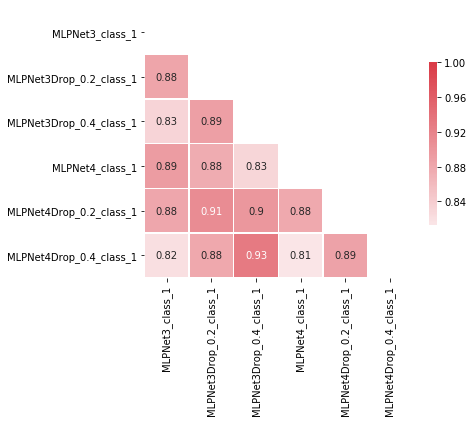

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain_mlp.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

## RANDOM FOREST PREDICTIONS

In [21]:
df_btrain_rf = pd.DataFrame({"Index test": X_train.reset_index().index.values})
df_bxval_rf = pd.DataFrame({"Index xval": X_xval.index.values})
df_btest_rf = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

model_type = "RandomForest_2"
path_pred  = "../predictions/%s" % model_type
list_criterion = ['gini', 'entropy']
list_max_features = ['sqrt']
list_max_depth = [10, 15, 25]
index_splits = [1, 2, 3, 4, 5]

for criterion in list_criterion:
    for max_features in list_max_features:
        for max_depth in list_max_depth:
            model_name = "rf_%s_%s_%s" % (criterion, max_features, max_depth)
            col_name = "%s_class_1" % model_name
            
            if not os.path.exists(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split))):
                pass
            else:
                df_btrain_rf.loc[:, col_name] = -1

                # On splits
                for index_split in index_splits:
                    df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split)))
                    df_pred_split.loc[:, col_name] = df_pred_split['Proba class 1']
                    df_btrain_rf.loc[df_btrain_rf['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

                # On xval data
                df_pred_xval = pd.read_csv(os.path.join(path_pred, "%s_xval.csv" % (model_name)))
                df_pred_xval.loc[:, col_name] = df_pred_xval['Proba class 1']
                df_bxval_rf = df_bxval_rf.merge(df_pred_xval[['Index xval', col_name]], how='left', on=['Index xval'])
                
                # On test data
                df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name)))
                df_pred_test.loc[:, col_name] = df_pred_test['Proba class 1']
                df_btest_rf = df_btest_rf.merge(df_pred_test[['Unique_ID', col_name]], how='left', on=['Unique_ID'])

In [22]:
df_btrain_rf.head()

,Index test,rf_gini_sqrt_10_class_1,rf_gini_sqrt_15_class_1,rf_gini_sqrt_25_class_1,rf_entropy_sqrt_10_class_1,rf_entropy_sqrt_15_class_1,rf_entropy_sqrt_25_class_1
0,0,0.568486,0.590265,0.591032,0.561993,0.582838,0.585934
1,1,0.524301,0.537997,0.564331,0.526261,0.537344,0.543804
2,2,0.453437,0.486185,0.514067,0.437979,0.505052,0.496878
3,3,0.962603,0.975092,0.972262,0.967127,0.990786,0.975836
4,4,0.526934,0.582683,0.702547,0.515435,0.559164,0.660550


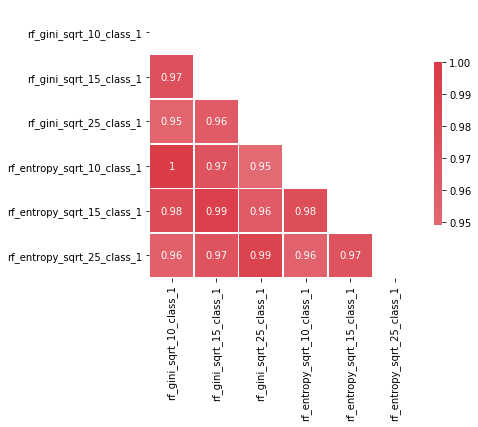

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain_rf.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

## LGBM PREDICTIONS

In [24]:
df_btrain_lgb = pd.DataFrame({"Index test": X_train.reset_index().index.values})
df_bxval_lgb = pd.DataFrame({"Index xval": X_xval.index.values})
df_btest_lgb = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

model_type = "LGBM_2"
list_boosting_type = ['gbdt']
list_num_leaves = [40, 60, 80]
index_splits = [1, 2, 3, 4, 5]

path_pred  = "../predictions/%s" % model_type

for boosting_type in list_boosting_type:
    for num_leaves in list_num_leaves:
        model_name = "lgb_%s_%s" % (boosting_type, num_leaves)
        col_name = "%s_class_1" % model_name
            
        if not os.path.exists(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split))):
            pass
        else:
            df_btrain_lgb.loc[:, col_name] = -1

            # On splits
            for index_split in index_splits:
                df_pred_split = pd.read_csv(os.path.join(path_pred, "%s_split_%d.csv" % (model_name, index_split)))
                df_pred_split.loc[:, col_name] = df_pred_split['Proba class 1']
                df_btrain_lgb.loc[df_btrain_lgb['Index test'].isin(df_pred_split['Index test']), col_name] = df_pred_split[col_name].values

            # On xval data
            df_pred_xval = pd.read_csv(os.path.join(path_pred, "%s_xval.csv" % (model_name)))
            df_pred_xval.loc[:, col_name] = df_pred_xval['Proba class 1']
            df_bxval_lgb = df_bxval_lgb.merge(df_pred_xval[['Index xval', col_name]], how='left', on=['Index xval'])

            # On test data
            df_pred_test = pd.read_csv(os.path.join(path_pred, "%s_test.csv" % (model_name)))
            df_pred_test.loc[:, col_name] = df_pred_test['Proba class 1']
            df_btest_lgb = df_btest_lgb.merge(df_pred_test[['Unique_ID', col_name]], how='left', on=['Unique_ID'])

In [25]:
df_btrain_lgb.head()

,Index test,lgb_gbdt_40_class_1,lgb_gbdt_60_class_1,lgb_gbdt_80_class_1
0,0,0.839122,0.805895,0.812826
1,1,0.670979,0.665511,0.742886
2,2,0.724325,0.734204,0.706818
3,3,0.998291,0.934786,0.978271
4,4,0.843723,0.817186,0.857106


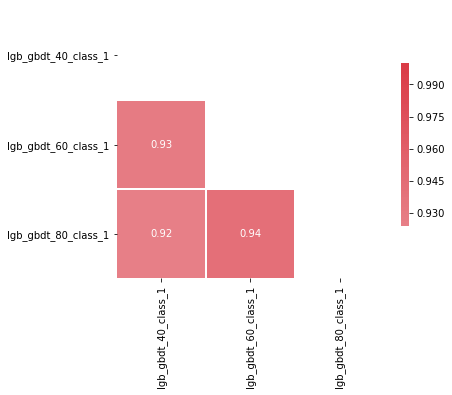

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain_lgb.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

# II. Combine all models

In [27]:
df_btrain = pd.DataFrame({"Index test": X_train.reset_index().index.values})
df_bxval= pd.DataFrame({"Index xval": X_xval.index.values})
df_btest = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

for btrain, bxval, btest in zip([df_btrain_mlp, df_btrain_rf, df_btrain_lgb],
                                [df_bxval_mlp, df_bxval_rf, df_bxval_lgb],
                                [df_btest_mlp, df_btest_rf, df_btest_lgb]):
    df_btrain = df_btrain.merge(btrain, how='left', on='Index test')
    df_bxval = df_bxval.merge(bxval, how='left', on='Index xval')
    df_btest = df_btest.merge(btest, how='left', on='Unique_ID')
# for btrain, bxval, btest in zip([df_btrain_mlp, df_btrain_rf],
#                                 [df_bxval_mlp, df_bxval_rf],
#                                 [df_btest_mlp, df_btest_rf]):
#     df_btrain = df_btrain.merge(btrain, how='left', on='Index test')
#     df_bxval = df_bxval.merge(bxval, how='left', on='Index xval')
#     df_btest = df_btest.merge(btest, how='left', on='Unique_ID')

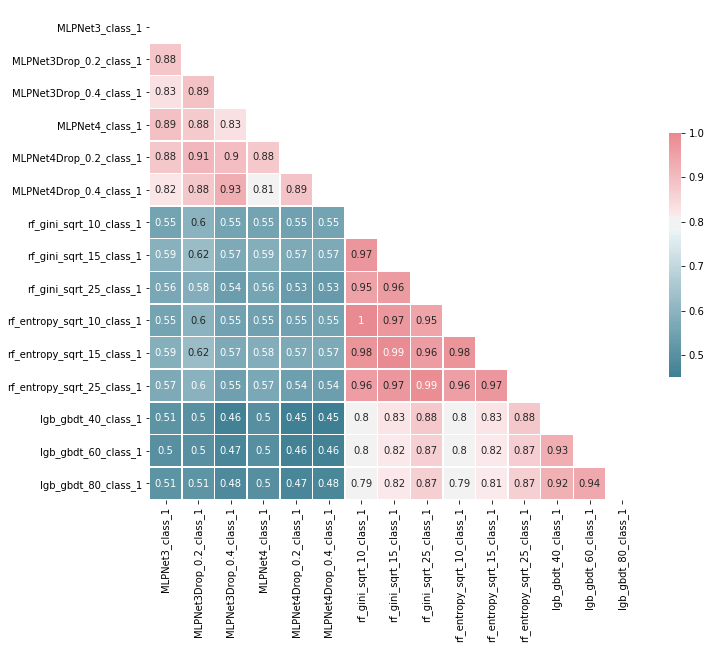

In [28]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

### GET YTRAIN, YXVAL

In [33]:
X_ttrain, y_train = mortgage_data.get_train()
X_txval, y_xval = mortgage_data.get_xval()

# Splits for cross-val of meta learner
bstrat_cv = StratifiedKFold(n_splits=5, shuffle=True,  random_state=random_state)

## II. 1 MEAN PROBA

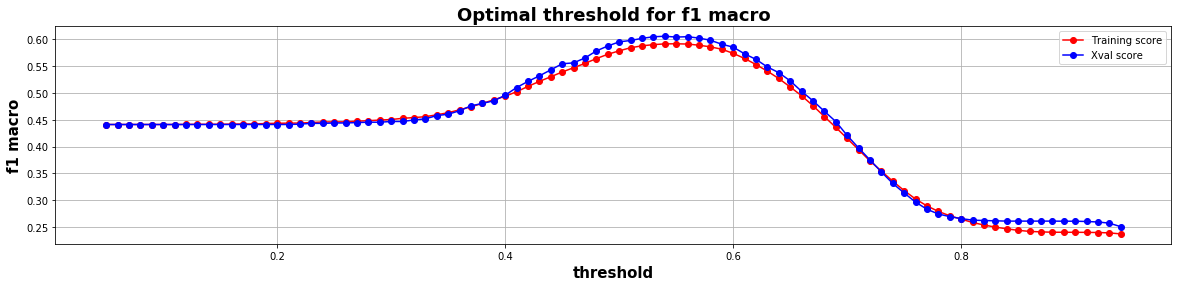

CPU times: user 836 ms, sys: 20.3 ms, total: 857 ms
Wall time: 863 ms


In [34]:
%%time
warnings.filterwarnings('ignore')

# See which threshold yields the best f1_macro on validation set
y_prob_train = df_btrain.iloc[:, 1:].mean(axis=1)
y_prob_xval = df_bxval.iloc[:, 1:].mean(axis=1)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

warnings.filterwarnings('ignore')

In [35]:
y_pred_train = np.where(df_btrain.iloc[:, 1:].mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)

print("="*40)
print("Train")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred_xval = np.where(df_bxval.iloc[:, 1:].mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_xval, y_xval)
print("="*40)
print("Xval")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Class 0 | precision 0.3516; recall 0.3684; f1 0.3598 
Class 1 | precision 0.8292; recall 0.8186; f1 0.8238 
Xval
Class 0 | precision 0.3758; recall 0.3846; f1 0.3801 
Class 1 | precision 0.8346; recall 0.8294; f1 0.832 


## II.2 Logistic regression

In [36]:
def f1_macro_score(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:, 1]
    y_pred = np.where(y_pred_proba > 0.70, 1, 0)
    return f1_score(y_pred, y_true, average='macro')

In [37]:
%%time
clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-1, 3, 10), 'penalty':['l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(df_btrain.iloc[:, 1:], y_train)
lr_best_estimator = grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    3.7s


CPU times: user 444 ms, sys: 108 ms, total: 552 ms
Wall time: 4.82 s


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.6s finished


Best params {'C': 16.68100537200059, 'penalty': 'l2'}


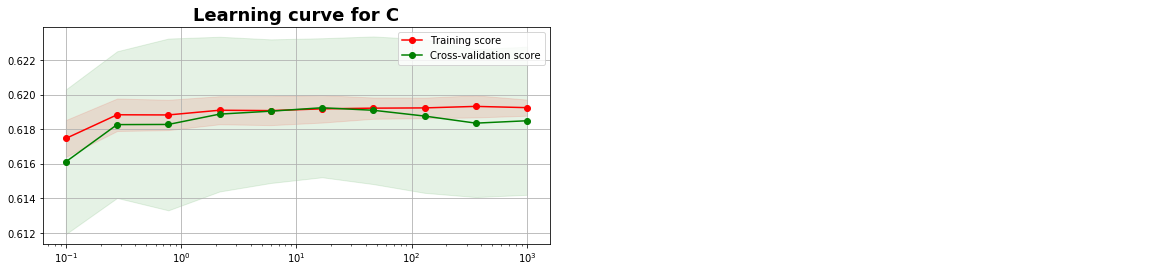

In [38]:
print("Best params %s" % grid.best_params_)
plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

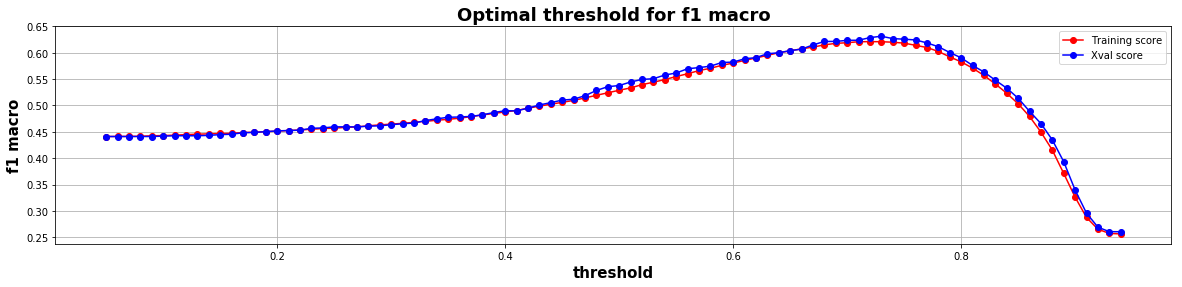

CPU times: user 934 ms, sys: 45.1 ms, total: 980 ms
Wall time: 787 ms


In [39]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = lr_best_estimator.predict_proba(df_btrain.iloc[:, 1:])[:,1]
y_prob_xval = lr_best_estimator.predict_proba(df_bxval.iloc[:, 1:])[:,1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [40]:
y_pred_train = np.where(y_prob_train > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)

print("="*40)
print("Train")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred_xval = np.where(y_prob_xval > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_xval, y_xval)
print("="*40)
print("Xval")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Class 0 | precision 0.3852; recall 0.4492; f1 0.4147 
Class 1 | precision 0.8461; recall 0.8085; f1 0.8269 
Xval
Class 0 | precision 0.3989; recall 0.4705; f1 0.4318 
Class 1 | precision 0.8515; recall 0.8107; f1 0.8306 


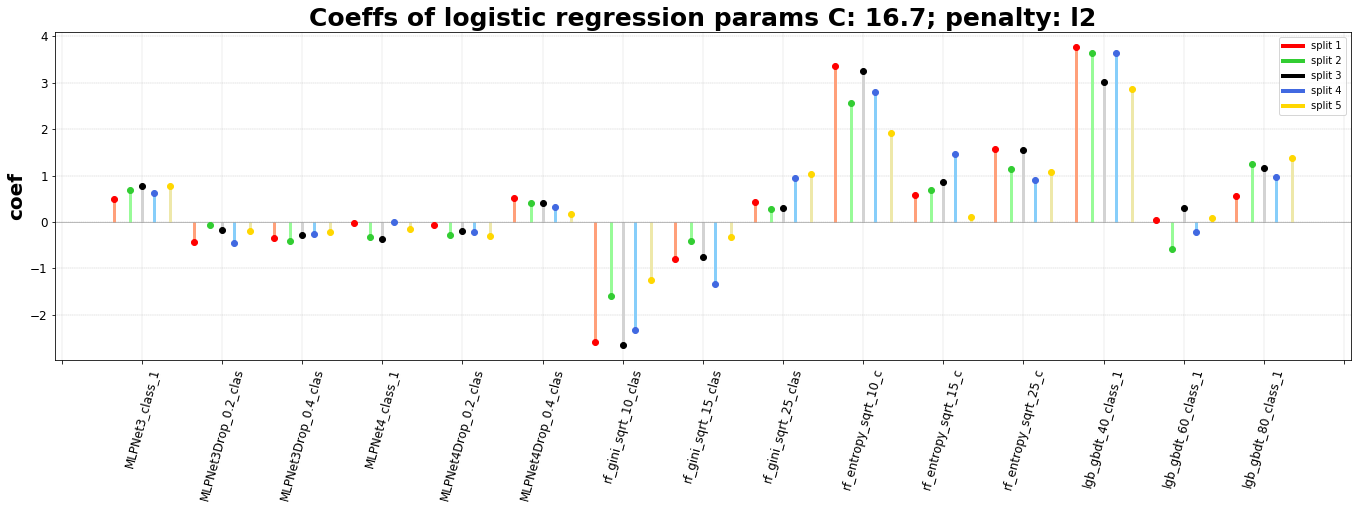

In [41]:
# Compute coefficients on each split with best params
estimator = clone(lr_best_estimator)
splits = bstrat_cv.split(df_btrain.iloc[:,1:], y_train)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(df_btrain.iloc[idx_train, 1:], y_train.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=df_btrain.iloc[:,1:].columns)
    list_coeffs.append(coeffs)

# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

### Make a prediction

In [43]:
path_sub = "../submissions/mortgage_4"
path_model = "../trained_models/mortgage_4"
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

y_prob_test = lr_best_estimator.predict_proba(df_btest.iloc[:, 1:])[:,1]
df_bpred = pd.DataFrame({'Unique_ID': df_btest['Unique_ID']})
df_bpred.loc[:, 'Result_Predicted'] =  np.where(y_prob_test > best_th, 1, 0)
df_bpred.loc[:, 'Result_Predicted']  = df_bpred['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(df_bpred[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "lr_meta_mlp_rf_lgb.csv"), index=False)

# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, 'lr_meta_mlp_rf_lgb.pkl'))

['../trained_models/mortgage_4/lr_meta_mlp_rf_lgb.pkl']

## II.3 Random Forest

In [44]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [500], 
              'max_depth': [10, 20, 30, 40]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(df_btrain.iloc[:, 1:], y_train)
rf_best_estimator = grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  6.4min finished


CPU times: user 1min 5s, sys: 800 ms, total: 1min 5s
Wall time: 7min 34s


Best params {'max_depth': 30, 'n_estimators': 500}


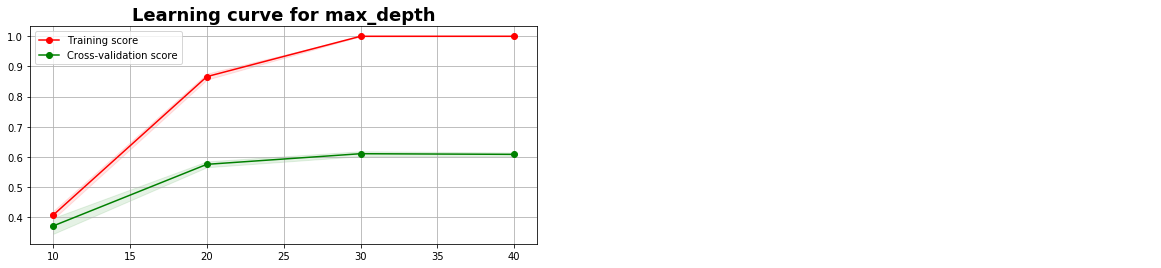

In [45]:
print("Best params %s" % grid.best_params_)
plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=[])

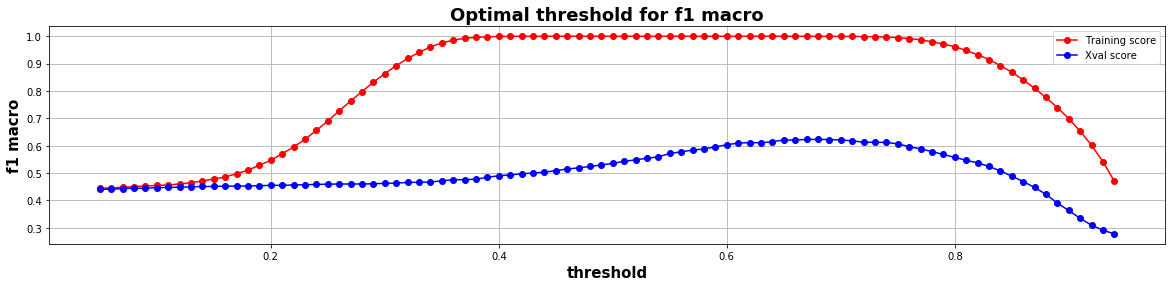

CPU times: user 5.09 s, sys: 366 ms, total: 5.45 s
Wall time: 5.48 s


In [46]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = rf_best_estimator.predict_proba(df_btrain.iloc[:, 1:])[:,1]
y_prob_xval = rf_best_estimator.predict_proba(df_bxval.iloc[:, 1:])[:,1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

# II. Combine all models

In [171]:
df_btrain = pd.DataFrame({"Index test": X_train.reset_index().index.values})
df_bxval= pd.DataFrame({"Index xval": X_xval.index.values})
df_btest = pd.DataFrame({"Unique_ID": X_test.unique_id.values})

# for btrain, bxval, btest in zip([df_btrain_mlp, df_btrain_rf, df_btrain_lgb],
#                                 [df_bxval_mlp, df_bxval_rf, df_bxval_lgb],
#                                 [df_btest_mlp, df_btest_rf, df_btest_lgb]):
#     df_btrain = df_btrain.merge(btrain, how='left', on='Index test')
#     df_bxval = df_bxval.merge(bxval, how='left', on='Index xval')
#     df_btest = df_btest.merge(btest, how='left', on='Unique_ID')
for btrain, bxval, btest in zip([df_btrain_mlp, df_btrain_rf],
                                [df_bxval_mlp, df_bxval_rf],
                                [df_btest_mlp, df_btest_rf]):
    df_btrain = df_btrain.merge(btrain, how='left', on='Index test')
    df_bxval = df_bxval.merge(bxval, how='left', on='Index xval')
    df_btest = df_btest.merge(btest, how='left', on='Unique_ID')

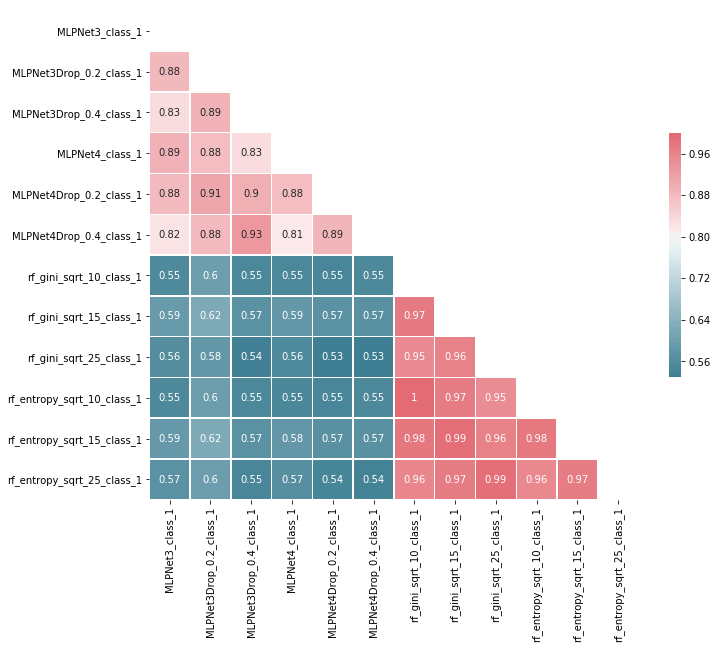

In [172]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = df_btrain.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0.8, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

### GET YTRAIN, YXVAL

In [173]:
X_ttrain, y_train = mortgage_data.get_train()
X_txval, y_xval = mortgage_data.get_xval()

# Check that the order of y_train indeed corresponds to the order of X_ttrain
df_btrain.insert(1, column='Index train', value=X_ttrain.index)
assert(all(df_btrain['Index train'] == y_train.index))
del df_btrain['Index train']

# Splits for cross-val of meta learner
bstrat_cv = StratifiedKFold(n_splits=5, shuffle=True,  random_state=random_state)

## II. 1 MEAN PROBA

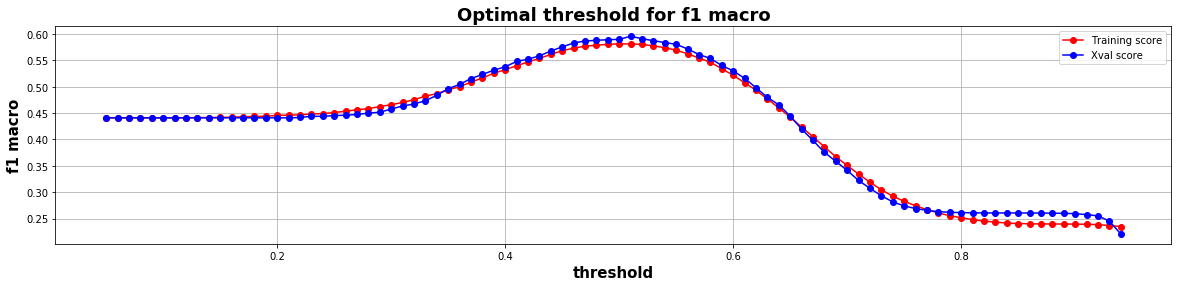

CPU times: user 820 ms, sys: 18.3 ms, total: 838 ms
Wall time: 842 ms


In [174]:
%%time
warnings.filterwarnings('ignore')

# See which threshold yields the best f1_macro on validation set
y_prob_train = df_btrain.iloc[:, 1:].mean(axis=1)
y_prob_xval = df_bxval.iloc[:, 1:].mean(axis=1)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

warnings.filterwarnings('ignore')

In [175]:
y_pred_train = np.where(df_btrain.iloc[:, 1:].mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)

print("="*40)
print("Train")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred_xval = np.where(df_bxval.iloc[:, 1:].mean(axis=1) > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_xval, y_xval)
print("="*40)
print("Xval")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Class 0 | precision 0.3249; recall 0.4073; f1 0.3614 
Class 1 | precision 0.8302; recall 0.774; f1 0.8011 
Xval
Class 0 | precision 0.3486; recall 0.4123; f1 0.3778 
Class 1 | precision 0.835; recall 0.7942; f1 0.8141 


## II.2 Logistic regression

In [176]:
def f1_macro_score(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:, 1]
    y_pred = np.where(y_pred_proba > 0.70, 1, 0)
    return f1_score(y_pred, y_true, average='macro')

In [177]:
%%time
clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-1, 3, 10), 'penalty':['l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(df_btrain.iloc[:, 1:], y_train)
lr_best_estimator = grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


CPU times: user 567 ms, sys: 275 ms, total: 842 ms
Wall time: 3.46 s


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.3s finished


Best params {'C': 5.994842503189409, 'penalty': 'l2'}


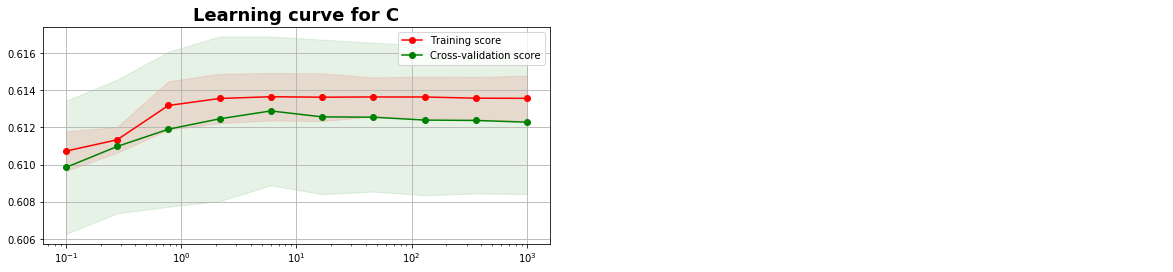

In [178]:
print("Best params %s" % grid.best_params_)
plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

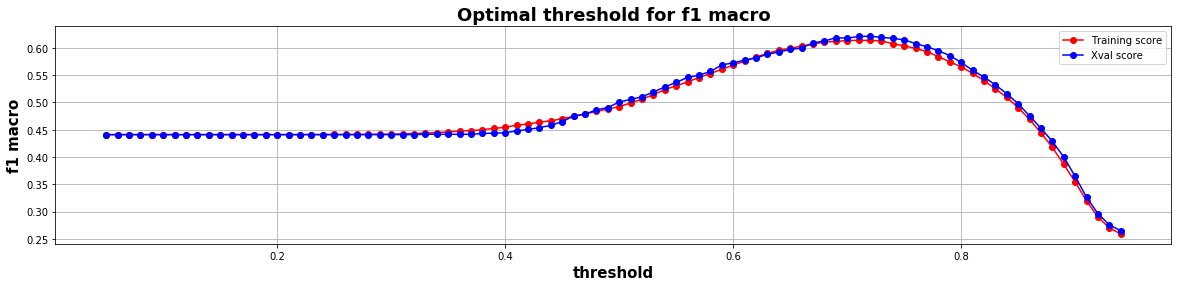

CPU times: user 946 ms, sys: 43.6 ms, total: 989 ms
Wall time: 793 ms


In [179]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = lr_best_estimator.predict_proba(df_btrain.iloc[:, 1:])[:,1]
y_prob_xval = lr_best_estimator.predict_proba(df_bxval.iloc[:, 1:])[:,1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [180]:
y_pred_train = np.where(y_prob_train > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)

print("="*40)
print("Train")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

y_pred_xval = np.where(y_prob_xval > best_th, 1, 0)
recalls, precisions, f1s = f1_macro(y_pred_xval, y_xval)
print("="*40)
print("Xval")
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Train
Class 0 | precision 0.3719; recall 0.4502; f1 0.4073 
Class 1 | precision 0.8444; recall 0.7969; f1 0.82 
Xval
Class 0 | precision 0.3828; recall 0.4629; f1 0.4191 
Class 1 | precision 0.8481; recall 0.8007; f1 0.8237 


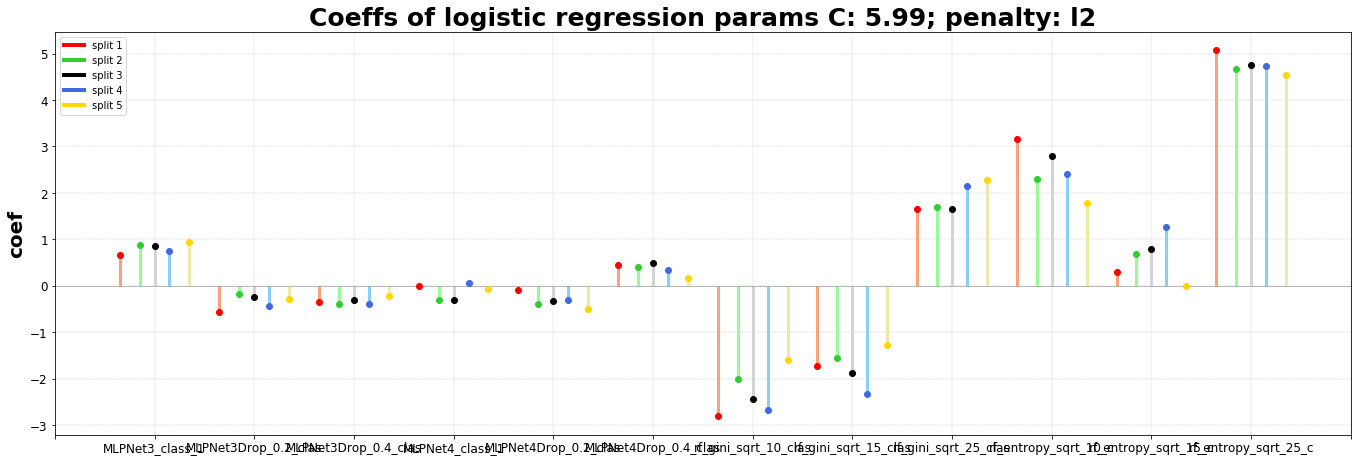

In [181]:
# Compute coefficients on each split with best params
estimator = clone(lr_best_estimator)
splits = bstrat_cv.split(df_btrain.iloc[:,1:], y_train)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(df_btrain.iloc[idx_train, 1:], y_train.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=df_btrain.iloc[:,1:].columns)
    list_coeffs.append(coeffs)

# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

## II.3 Random Forest

In [183]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [100, 200, 400, 600], 
              'max_depth': [20, 30]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring=f1_macro_score, 
                    cv=bstrat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(df_btrain.iloc[:, 1:], y_train)
rf_best_estimator = grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  8.3min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 11.2min finished


CPU times: user 1min 14s, sys: 1.15 s, total: 1min 15s
Wall time: 12min 27s


Best params {'max_depth': 30, 'n_estimators': 600}


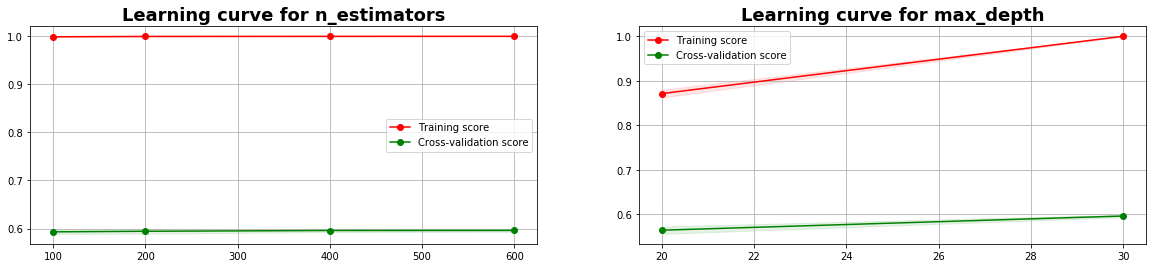

In [184]:
print("Best params %s" % grid.best_params_)
plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=[])

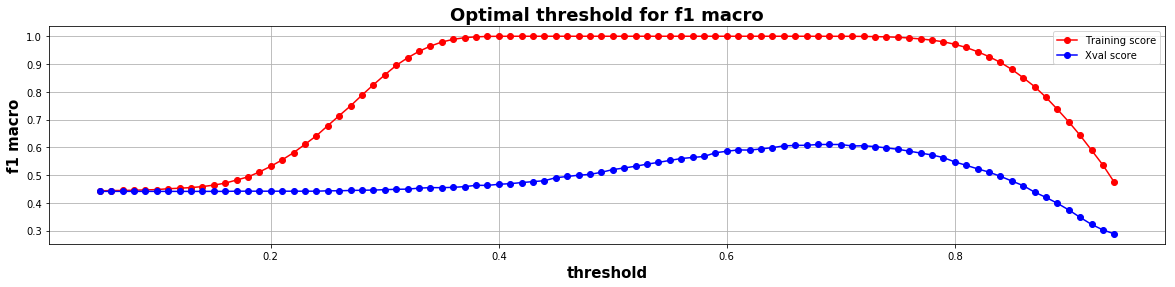

CPU times: user 6.54 s, sys: 546 ms, total: 7.09 s
Wall time: 7.71 s


In [185]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = rf_best_estimator.predict_proba(df_btrain.iloc[:, 1:])[:,1]
y_prob_xval = rf_best_estimator.predict_proba(df_bxval.iloc[:, 1:])[:,1]

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_xval = []
best_th = 0
best_f1_xval = 0

for th in thresh:
    f1_train = f1_score(y_train, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_xval = f1_score(y_xval, np.where(y_prob_xval > th, 1, 0), average='macro')
    if f1_xval > best_f1_xval:
        best_f1_xval = f1_xval
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_xval.append(f1_xval)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_xval, 'o-', color="blue", label="Xval score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)